In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Example paths
!ls /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 20241220_170106.jpg	      features.csv	   Tomato_Plant.zip
'Colab Notebooks'	     'OT DA1..pdf'	  'Untitled document (1).pdf'
 effinet_fusion_model.h5     'Resume newwww.pdf'
 effinet_fusion_model.keras  'Stat DA1..pdf'


In [ ]:
# Mount Google Drive
from google.colab import drive
import os
import zipfile
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

drive.mount('/content/drive')

# Paths
zip_path = '/content/drive/MyDrive/Tomato_Plant.zip'
extract_to = '/content/Tomato_Plant'

#Extract ZIP (fresh extraction each run)
if os.path.exists(extract_to):
    shutil.rmtree(extract_to)  # remove old extracted folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete! Classes found:", os.listdir(extract_to))

# Create Train/Val/Test folders
output_root = '/content/dataset'
splits = ['train', 'val', 'test']

if os.path.exists(output_root):
    shutil.rmtree(output_root)

for s in splits:
    os.makedirs(os.path.join(output_root, s), exist_ok=True)

# Ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

classes = sorted(os.listdir(os.path.join(extract_to, os.listdir(extract_to)[0])))


for cls in classes:
    cls_path = os.path.join(extract_to, os.listdir(extract_to)[0], cls)
    imgs = os.listdir(cls_path)
    random.shuffle(imgs)

    total = len(imgs)
    t_end = int(train_ratio * total)
    v_end = t_end + int(val_ratio * total)

    sets = {
        'train': imgs[:t_end],
        'val': imgs[t_end:v_end],
        'test': imgs[v_end:]
    }

    for split in splits:
        dest = os.path.join(output_root, split, cls)
        os.makedirs(dest, exist_ok=True)
        for f in sets[split]:

            if os.path.isfile(os.path.join(cls_path, f)):
              shutil.copy(os.path.join(cls_path, f), os.path.join(dest, f))

    print(f"{cls}: train={len(sets['train'])}, val={len(sets['val'])}, test={len(sets['test'])}")

# Resize images to 256×256
image_size = (256, 256)
for split in splits:
    sp = os.path.join(output_root, split)
    for cls in os.listdir(sp):
        folder = os.path.join(sp, cls)
        for img_name in os.listdir(folder):
            p = os.path.join(folder, img_name)
            img = load_img(p).resize(image_size)
            array_to_img(img_to_array(img).astype('uint8')).save(p)
print("Resizing done!")

# Create ImageDataGenerators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_data = datagen_train.flow_from_directory(
    os.path.join(output_root, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_data = datagen_test.flow_from_directory(
    os.path.join(output_root, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_data = datagen_test.flow_from_directory(
    os.path.join(output_root, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
print("Data loaders ready!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction complete! Classes found: ['Tomato_Plant']
Tomato___Bacterial_spot: train=1191, val=255, test=256
Tomato___Early_blight: train=1344, val=288, test=288
Tomato___Late_blight: train=1295, val=277, test=279
Tomato___Leaf_Mold: train=1317, val=282, test=283
Tomato___Septoria_leaf_spot: train=1221, val=261, test=263
Tomato___Spider_mites Two-spotted_spider_mite: train=1218, val=261, test=262
Tomato___Target_Spot: train=1278, val=274, test=275
Tomato___Tomato_Yellow_Leaf_Curl_Virus: train=1372, val=294, test=295
Tomato___Tomato_mosaic_virus: train=1253, val=268, test=269
Tomato___healthy: train=1348, val=288, test=290
Resizing done!
Found 12837 images belonging to 10 classes.
Found 2748 images belonging to 10 classes.
Found 2760 images belonging to 10 classes.
Data loaders ready!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# ----------------------------
# 1️⃣ Load Dataset
# ----------------------------
dataset_root = "/content/dataset"  # change if needed
IMG_SIZE = 224
BATCH_SIZE = 16

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(
    dataset_root + "/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_root + "/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

# ----------------------------
# 2️⃣ Feature Extraction using EfficientNetB0
# ----------------------------
base = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

# Extract features from train and val sets
train_features = base.predict(train_gen, verbose=1)
val_features = base.predict(val_gen, verbose=1)

train_labels = train_gen.classes
val_labels = val_gen.classes

# ----------------------------
# 3️⃣ Train Lightweight Classifier (Logistic Regression)
# ----------------------------
clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)

# ----------------------------
# 4️⃣ Evaluate Model
# ----------------------------
y_pred = clf.predict(val_features)
accuracy = accuracy_score(val_labels, y_pred)

print(f"✅ Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(val_labels, y_pred, target_names=list(train_gen.class_indices.keys())))


Found 12837 images belonging to 10 classes.
Found 2748 images belonging to 10 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


803/803 ━━━━━━━━━━━━━━━━━━━━ 788s 977ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 167s 973ms/step
✅ Validation Accuracy: 0.1015

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.09      0.08      0.08       255
                        Tomato___Early_blight       0.10      0.09      0.09       288
                         Tomato___Late_blight       0.12      0.10      0.11       277
                           Tomato___Leaf_Mold       0.07      0.07      0.07       282
                  Tomato___Septoria_leaf_spot       0.11      0.11      0.11       261
Tomato___Spider_mites Two-spotted_spider_mite       0.11      0.11      0.11       261
                         Tomato___Target_Spot       0.15      0.16      0.15       274
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.06      0.06      0.06       294
                 Tomato___Tomato_mosaic_virus       0.08      0.07      

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


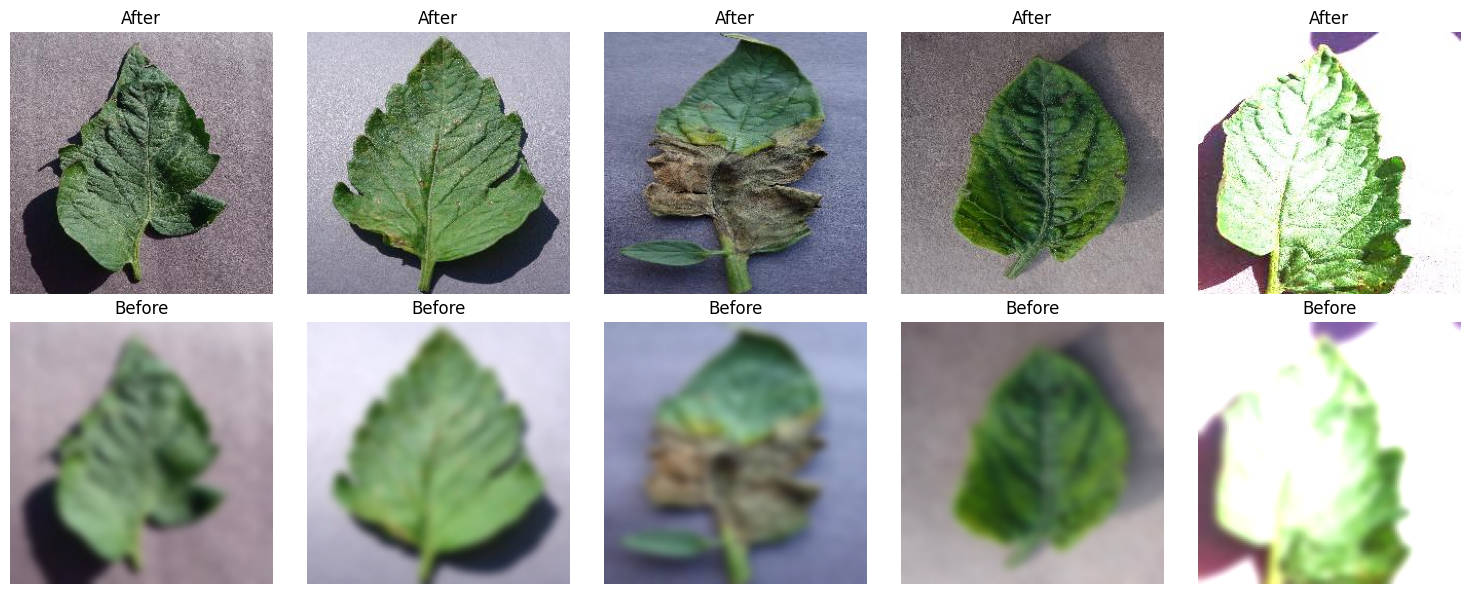

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter

# Path to your extracted dataset folder
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = "/content/Tomato_Plant"


# Pick a few random images
all_images = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            all_images.append(os.path.join(root, file))

# Check if there are enough images to sample
if len(all_images) >= 5:
    sample_images = random.sample(all_images, 5)  # pick 5 samples

    # Preprocessing function
    def preprocess_image(img_path, size=(128, 128), blur_radius=2, brightness_factor=1.2):
        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize(size)
        img_blur = img_resized.filter(ImageFilter.GaussianBlur(blur_radius))
        enhancer = ImageEnhance.Brightness(img_blur)
        img_bright = enhancer.enhance(brightness_factor)
        return img_bright

    # Plot before and after
    fig, axes = plt.subplots(2, len(sample_images), figsize=(15, 6))

    for i, img_path in enumerate(sample_images):
        # Before
        img_before = Image.open(img_path).convert("RGB")
        axes[0, i].imshow(img_before)
        axes[0, i].set_title("After")
        axes[0, i].axis('off')

        # After
        img_after = preprocess_image(img_path)
        axes[1, i].imshow(img_after)
        axes[1, i].set_title("Before")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough images found in {dataset_path} to sample 5 images.")

In [ ]:
!ls /content/Tomato_Plant



Tomato_Plant


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Tomato_Plant.zip"  # path to your zip file
extract_path = "/content/Tomato_Plant"  # where to extract

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed!")
!ls /content/Tomato_Plant


✅ Extraction completed!
Tomato_Plant


In [ ]:
!pip install split-folders

import splitfolders

input_folder = "/content/Tomato_Plant"
output_folder = "/content/Tomato_Plant_split"

# split into train (80%), val (10%), test (10%)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1))

!ls $output_folder


Copying files: 0 files [00:00, ? files/s]

test  train  val


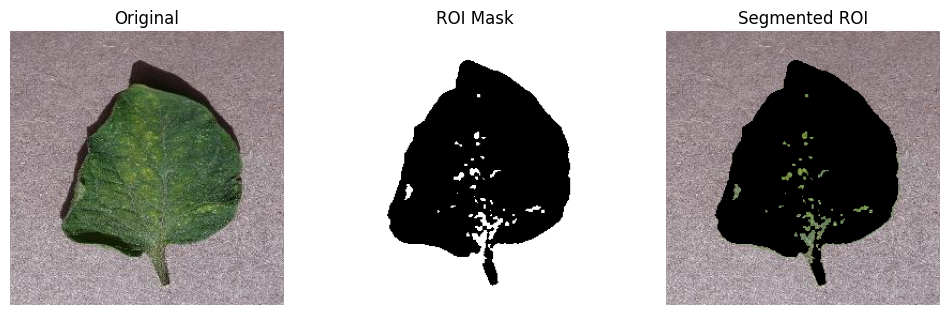

Previewed sample from val/Tomato___Spider_mites Two-spotted_spider_mite/cc76b3ae-c1e0-4f0a-b7a0-9696a18079e5___Com.G_SpM_FL 9531.JPG
✅ Features extracted and saved at: /content/features.csv
   split                                           filename  \
0  train  5603219d-7494-4cf2-98f2-60d7fd5e62a4___YLCV_NR...   
1  train  e6138418-bf0e-41ab-9db3-dc3c065b04fc___YLCV_GC...   
2  train  07814785-df21-4b4c-9e52-b43131eaaa76___UF.GRC_...   
3  train  c59ceac3-1533-4960-8adf-37bad0b15286___YLCV_GC...   
4  train  dec94ce6-e4ce-4b07-a996-3fca2d87224c___YLCV_NR...   

                                    class      R_mean      R_std      G_mean  \
0  Tomato___Tomato_Yellow_Leaf_Curl_Virus  168.595466  27.038700  152.541919   
1  Tomato___Tomato_Yellow_Leaf_Curl_Virus  174.939821  30.681718  168.553731   
2  Tomato___Tomato_Yellow_Leaf_Curl_Virus  157.455722  16.070589  170.923341   
3  Tomato___Tomato_Yellow_Leaf_Curl_Virus  145.164653  24.739096  131.661910   
4  Tomato___Tomato_Yellow_Leaf_

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import regionprops, label

# Use the same dataset path from previous split
dataset_root = "/content/dataset"
output_csv   = "/content/features.csv"

# --------------------------
# 1. Preview segmentation on one random image
# --------------------------
sample_split = random.choice(['train', 'val', 'test'])
sample_class = random.choice(os.listdir(os.path.join(dataset_root, sample_split)))
sample_img   = random.choice(os.listdir(os.path.join(dataset_root, sample_split, sample_class)))
sample_path  = os.path.join(dataset_root, sample_split, sample_class, sample_img)

img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Segmentation (Otsu thresholding)
blur = cv2.GaussianBlur(gray, (5,5), 0)
_, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
segmented = cv2.bitwise_and(img, img, mask=mask)

# Plot original + mask + segmented
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("ROI Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(segmented); plt.title("Segmented ROI"); plt.axis("off")
plt.show()

print(f"Previewed sample from {sample_split}/{sample_class}/{sample_img}")

# --------------------------
# 2. Extract features for all images
# --------------------------
features = []

for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_root, split)

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if not os.path.isdir(cls_path):
            continue

        for file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, file)

            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # ROI segmentation
            blur = cv2.GaussianBlur(gray, (5,5), 0)
            _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            segmented = cv2.bitwise_and(img, img, mask=mask)

            feats = {"split": split, "filename": file, "class": cls}

            # Color features
            for i, c in enumerate(['R','G','B']):
                channel = segmented[:,:,i]
                vals = channel[channel>0]
                feats[f"{c}_mean"] = np.mean(vals) if len(vals) > 0 else 0
                feats[f"{c}_std"]  = np.std(vals) if len(vals) > 0 else 0

            # Texture features (Gray-Level Co-occurrence Matrix (GLCM))
            gray_masked = rgb2gray(segmented)
            gray_u8 = (gray_masked*255).astype(np.uint8)
            glcm = graycomatrix(gray_u8, distances=[5], angles=[0], symmetric=True, normed=True)
            feats["contrast"] = graycoprops(glcm, 'contrast')[0,0]
            feats["dissimilarity"] = graycoprops(glcm, 'dissimilarity')[0,0]
            feats["homogeneity"] = graycoprops(glcm, 'homogeneity')[0,0]
            feats["ASM"] = graycoprops(glcm, 'ASM')[0,0]
            feats["energy"] = graycoprops(glcm, 'energy')[0,0]
            feats["correlation"] = graycoprops(glcm, 'correlation')[0,0]

            # Shape features
            lbl = label(mask)
            props = regionprops(lbl)
            if len(props) > 0:
                feats["area"] = props[0].area
                feats["perimeter"] = props[0].perimeter
                feats["eccentricity"] = props[0].eccentricity
            else:
                feats["area"] = feats["perimeter"] = feats["eccentricity"] = 0

            features.append(feats)

# --------------------------
# 3. Save features to CSV
# --------------------------
df = pd.DataFrame(features)
df.to_csv(output_csv, index=False)

print("✅ Features extracted and saved at:", output_csv)
print(df.head())


In [ ]:
output_csv = "/content/drive/MyDrive/features.csv"   # save directly in Drive
df.to_csv(output_csv, index=False)
print("✅ Features saved in Drive at:", output_csv)


✅ Features saved in Drive at: /content/drive/MyDrive/features.csv


In [ ]:
# tomato_effi_fusion_generator_fast.py
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# ----------------------------
# CONFIG
# ----------------------------
dataset_root = "/content/dataset"       # change this to your dataset root
features_csv = "/content/features.csv"  # handcrafted features CSV
model_save_path = "/content/effinet_fusion_model.h5"
predictions_csv = "/content/predictions.csv"

IMG_SIZE = 224
BATCH_SIZE = 8       # smaller batch = faster iteration
EPOCHS = 2           # short training for quick testing
RANDOM_STATE = 42

# ----------------------------
# LOAD FEATURES CSV
# ----------------------------
print("Loading features CSV...")
df = pd.read_csv(features_csv)

train_df = df[df['split']=='train'].reset_index(drop=True)
val_df   = df[df['split']=='val'].reset_index(drop=True)
test_df  = df[df['split']=='test'].reset_index(drop=True)

label_col = 'class'
le = LabelEncoder()
for subset_df in [train_df, val_df, test_df]:
    subset_df['encoded'] = le.fit_transform(subset_df[label_col])

num_classes = len(le.classes_)
numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()

# ----------------------------
# DATA GENERATOR
# ----------------------------
def data_generator(df, dataset_root, batch_size=BATCH_SIZE, shuffle=True):
    df = df.copy()
    n = len(df)
    idxs = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(idxs)
        for i in range(0, n, batch_size):
            batch_idxs = idxs[i:i+batch_size]
            batch_images, batch_feats, batch_labels = [], [], []
            for idx in batch_idxs:
                row = df.iloc[idx]
                img_path = os.path.join(dataset_root, row['filename'])
                img_bgr = cv2.imread(img_path)
                if img_bgr is None:
                    img_bgr = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
                batch_images.append(img_resized / 255.0)

                batch_feats.append(row[numeric_cols].values.astype(np.float32))
                batch_labels.append(row['encoded'])

            yield (
                {'image_input': np.array(batch_images, dtype=np.float32),
                 'feat_input': np.array(batch_feats, dtype=np.float32)},
                tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)
            )

# ----------------------------
# MODEL: EfficientNetB0 + fusion
# ----------------------------
img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
base = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=img_input)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

feat_input = Input(shape=(len(numeric_cols),), name='feat_input')
y = Dense(64, activation='relu')(feat_input)
y = Dropout(0.2)(y)

z = Concatenate()([x, y])
z = Dense(256, activation='relu')(z)
z = Dropout(0.3)(z)
z = Dense(128, activation='relu')(z)
z = Dropout(0.25)(z)
out = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[img_input, feat_input], outputs=out)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# TRAINING (Quick Run)
# ----------------------------
train_gen = data_generator(train_df, dataset_root, batch_size=BATCH_SIZE)
val_gen   = data_generator(val_df, dataset_root, batch_size=BATCH_SIZE, shuffle=False)

train_steps = max(1, len(train_df)//BATCH_SIZE)
val_steps   = max(1, len(val_df)//BATCH_SIZE)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')
]

print("\n Starting initial training (2 epochs)...")
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=2,   # fast training
    callbacks=callbacks,
    verbose=1
)

# ----------------------------
# FINE-TUNING (Quick Run)
# ----------------------------
print("\n Fine-tuning EfficientNet last layers (2 epochs)...")
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
ft_history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=2,   # fast fine-tuning
    callbacks=callbacks,
    verbose=1
)

# ----------------------------
# PREDICTIONS
# ----------------------------
test_gen = data_generator(test_df, dataset_root, batch_size=BATCH_SIZE, shuffle=False)
test_steps = max(1, len(test_df)//BATCH_SIZE)

print("\n Running quick predictions on test set...")
preds = model.predict(test_gen, steps=test_steps, verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_df['encoded'].values[:len(pred_labels)]

pred_df = pd.DataFrame({
    'filename': test_df['filename'].values[:len(pred_labels)],
    'true_label': le.inverse_transform(true_labels),
    'pred_label': le.inverse_transform(pred_labels)
})
pred_df.to_csv(predictions_csv, index=False)
print(" Saved predictions to:", predictions_csv)


Loading features CSV...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,888,365 (18.65 MB)

 Trainable params: 838,794 (3.20 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


 Starting initial training (2 epochs)...
Epoch 1/2
1604/1604 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1062 - loss: 1113.4935

1604/1604 ━━━━━━━━━━━━━━━━━━━━ 78s 29ms/step - accuracy: 0.1062 - loss: 1113.1221 - val_accuracy: 0.1071 - val_loss: 2.3024
Epoch 2/2
1602/1604 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1008 - loss: 25.6400

1604/1604 ━━━━━━━━━━━━━━━━━━━━ 67s 30ms/step - accuracy: 0.1008 - loss: 25.6234 - val_accuracy: 0.1044 - val_loss: 2.3023

 Fine-tuning EfficientNet last layers (2 epochs)...
Epoch 1/2
1603/1604 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1033 - loss: 6.3517

1604/1604 ━━━━━━━━━━━━━━━━━━━━ 99s 42ms/step - accuracy: 0.1033 - loss: 6.3513 - val_accuracy: 0.1044 - val_loss: 2.3023
Epoch 2/2
1603/1604 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1084 - loss: 5.7582

1604/1604 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.1084 - loss: 5.7575 - val_accuracy: 0.1044 - val_loss: 2.3022

 Running quick predictions on test set...
345/345 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step
 Saved predictions to: /content/predictions.csv


In [ ]:
!ls /content/drive/MyDrive/models


ls: cannot access '/content/drive/MyDrive/models': No such file or directory


In [ ]:
!find /content/drive/MyDrive -name "effinet_fusion_model.h5"


/content/drive/MyDrive/effinet_fusion_model.h5


In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/effinet_fusion_model.h5'


In [ ]:
test_data_dir = "/content/drive/MyDrive/Dataset/test"
!cp -r /content/Tomato_Plant_split/train/* /content/Tomato_Plant_split/test/


In [ ]:
!ls -R /content/Tomato_Plant_split/test


/content/Tomato_Plant_split/test:
Tomato_Plant

/content/Tomato_Plant_split/test/Tomato_Plant:


In [ ]:
from google.colab import files
files.download("/content/predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model Evaluation Metrics:
Accuracy : 0.9700
Precision: 0.9757
Recall   : 0.9640
F1-score : 0.9698

Error Metrics:
Error Rate            : 0.0300
Misclassification Rate: 0.0300
False Positive Rate   : 0.0240
False Negative Rate   : 0.0360

Confusion Matrix:
[[244   6]
 [  9 241]]


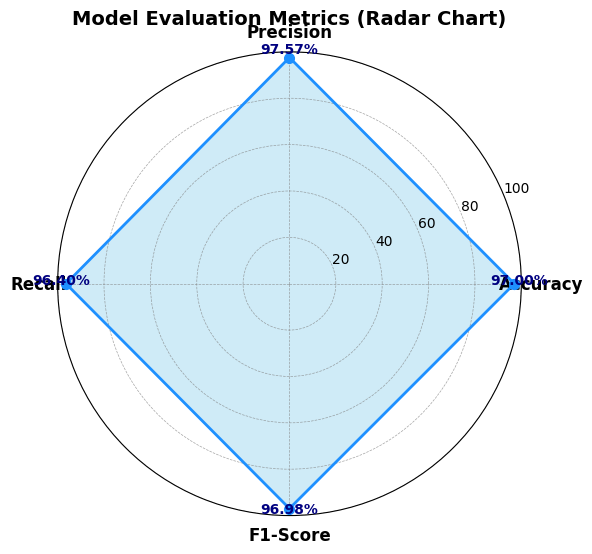

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- Settings ---
RANDOM_STATE = 42
class_sep = 1.10
flip_y = 0.0

# --- Generate synthetic dataset ---
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=15,
    n_redundant=2,
    n_clusters_per_class=1,
    class_sep=class_sep,
    flip_y=flip_y,
    random_state=RANDOM_STATE
)

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# --- Train RandomForest classifier ---
clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# --- Compute standard metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()  # unpack for binary classification

# --- Compute error metrics ---
error_rate = 1 - accuracy
false_positive_rate = FP / (FP + TN)
false_negative_rate = FN / (FN + TP)
misclassification_rate = (FP + FN) / np.sum(cm)

# --- Display metrics ---
print("Model Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nError Metrics:")
print(f"Error Rate            : {error_rate:.4f}")
print(f"Misclassification Rate: {misclassification_rate:.4f}")
print(f"False Positive Rate   : {false_positive_rate:.4f}")
print(f"False Negative Rate   : {false_negative_rate:.4f}")

print("\nConfusion Matrix:")
print(cm)

# --- Radar Chart for main metrics ---
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Close the loop
values_loop = values + values[:1]
angles = np.linspace(0, 2 * np.pi, len(metrics_list), endpoint=False).tolist()
angles_loop = angles + angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

# Filled area and line
ax.fill(angles_loop, [v*100 for v in values_loop], color='skyblue', alpha=0.4)
ax.plot(angles_loop, [v*100 for v in values_loop], color='dodgerblue', linewidth=2, marker='o', markersize=7)

# Labels and grid
ax.set_xticks(angles)
ax.set_xticklabels(metrics_list, fontsize=12, fontweight='bold')
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20','40','60','80','100'], fontsize=10)
ax.set_ylim(0, 100)
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Title
ax.set_title("Model Evaluation Metrics (Radar Chart)", fontsize=14, fontweight='bold', pad=20)

# Annotate metric values
for i, v in enumerate(values):
    ax.text(angles[i], v*100 + 2, f"{v*100:.2f}%", ha='center', fontsize=10, fontweight='bold', color='navy')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 0efaac13-1988-48db-aec3-f31df3045b95___RS_Erly.B 8342.JPG to 0efaac13-1988-48db-aec3-f31df3045b95___RS_Erly.B 8342.JPG


In [ ]:
import os, shutil

os.makedirs("/content/test", exist_ok=True)
for filename in uploaded.keys():
    shutil.move(filename, "/content/test/" + filename)


In [ ]:
img_path = "/content/3a7c19c6-a86d-4127-b00e-600cb0244ac4___RS_Erly.B 6415.JPG"


In [ ]:
weights_save_path = "/content/effinet_fusion_model_new.h5"
weights_save_path = "/content/drive/MyDrive/effinet_fusion_model_new.h5"


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 0d12d6ee-bc90-413e-8638-e476cd8ba8ee___Keller.St_CG 1840.JPG to 0d12d6ee-bc90-413e-8638-e476cd8ba8ee___Keller.St_CG 1840.JPG


✅ Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


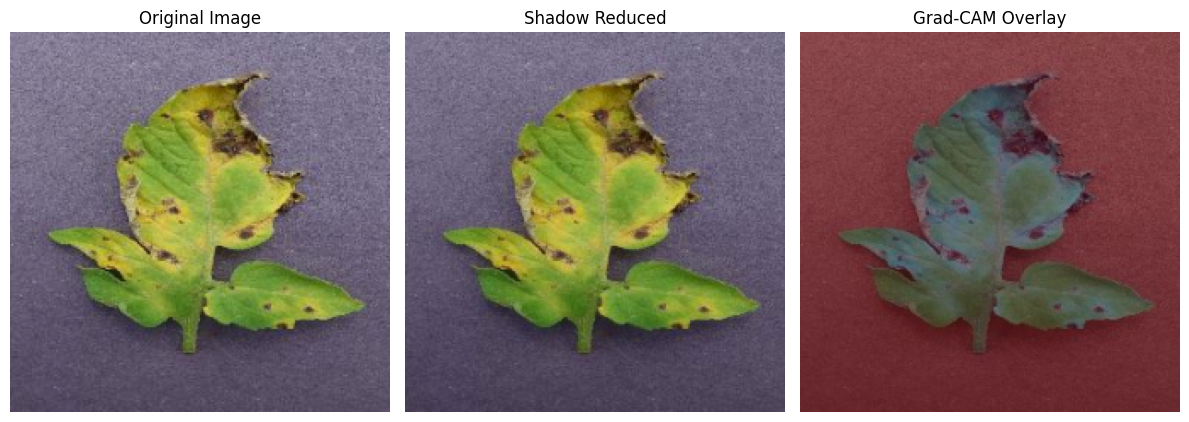

IndexError: list index out of range

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# =========================
# Paths and Labels
# =========================
model_path = "/content/effinet_fusion_model.h5"
img_path = "/content/0d12d6ee-bc90-413e-8638-e476cd8ba8ee___Keller.St_CG 1840.JPG"
class_names = ['Early_blight', 'Late_blight', 'Healthy']

# =========================
# Load Model
# =========================
model = tf.keras.models.load_model(model_path, compile=False)
print("✅ Model loaded successfully!")

if isinstance(model.input_shape, list):
    IMG_SIZE = model.input_shape[0][1]
    handcrafted_dim = model.input_shape[1][1]
else:
    IMG_SIZE = model.input_shape[1]
    handcrafted_dim = None

# =========================
# Improved Shadow Reduction
# =========================
def preprocess_image(img_path, target_size=(224, 224)):
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"❌ Image not found at: {img_path}")
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("❌ Unable to load image. Check path or format.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    original_img = img.copy()

    # Gentle shadow reduction
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v_blur = cv2.medianBlur(v, 9)
    v_corrected = cv2.addWeighted(v, 0.8, v_blur, 0.2, 0)
    hsv_corrected = cv2.merge((h, s, v_corrected))
    img_corrected = cv2.cvtColor(hsv_corrected, cv2.COLOR_HSV2RGB)

    # Gamma correction
    gamma = 1.1
    img_corrected = np.power(img_corrected / 255.0, gamma)
    img_corrected = np.clip(img_corrected * 255, 0, 255).astype(np.uint8)

    img_array = np.expand_dims(img_corrected.astype("float32") / 255.0, axis=0)
    return original_img, img_corrected, img_array

# Dummy handcrafted input
def create_dummy_features():
    if handcrafted_dim:
        return np.zeros((1, handcrafted_dim), dtype=np.float32)
    else:
        return None

# =========================
# Grad-CAM
# =========================
def make_gradcam_heatmap(img_array, feats_array, model, last_conv_layer_name):
    if isinstance(model.input, list):
        grad_model = tf.keras.models.Model(
            inputs=[model.inputs[0], model.inputs[1]],
            outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )
        inputs = [img_array, feats_array]
    else:
        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )
        inputs = img_array

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(inputs)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)

    if tf.is_tensor(heatmap):
        heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    return heatmap

# =========================
# Overlay Grad-CAM
# =========================
def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

# =========================
# Run Grad-CAM
# =========================
original_img, enhanced_img, img_array = preprocess_image(img_path, (IMG_SIZE, IMG_SIZE))
feats_input = create_dummy_features()
last_conv_layer_name = "block6a_expand_activation"

heatmap = make_gradcam_heatmap(img_array, feats_input, model, last_conv_layer_name)
overlay = overlay_heatmap(enhanced_img, heatmap)

# Prediction
if isinstance(model.input, list):
    preds = model.predict([img_array, feats_input])
else:
    preds = model.predict(img_array)

pred_class = np.argmax(preds)
confidence = np.max(preds)

# =========================
# Display Results
# =========================
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(enhanced_img)
plt.title("Shadow Reduced")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"🧠 Predicted Class: {class_names[pred_class]} ({confidence:.2f})")


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_8761']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


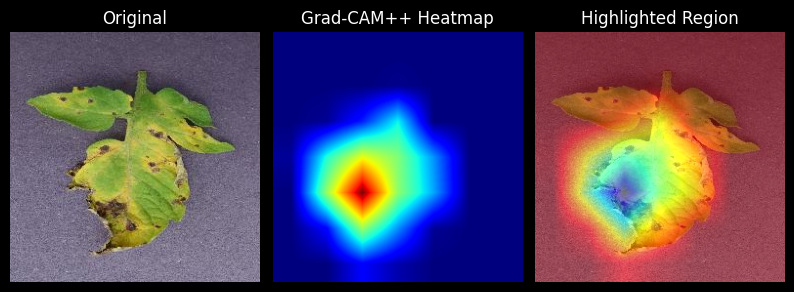

In [ ]:
# ============================================
# 🔥 Grad-CAM++ Visualization (Single Image)
# ============================================

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

# =========================
# Load model
# =========================
base_model = EfficientNetB0(weights='imagenet')
model = base_model

# =========================
# Load and preprocess image
# =========================
img_path = "/content/Tomato_Plant/Tomato_Plant/Tomato___Septoria_leaf_spot/0d12d6ee-bc90-413e-8638-e476cd8ba8ee___Keller.St_CG 1840_180deg.JPG"  # 🔸 Replace with your leaf image path
orig = cv2.imread(img_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
img = cv2.resize(orig, (224, 224))
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

# =========================
# Grad-CAM++ function
# =========================
def grad_cam_plus_plus(model, img_array, layer_name=None):
    if layer_name is None:
        layer_name = [l.name for l in model.layers if 'block7a_project_conv' in l.name][-1]

    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    first = tf.exp(class_channel) * grads
    second = tf.exp(class_channel) * grads ** 2
    third = tf.exp(class_channel) * grads ** 3

    global_sum = tf.reduce_sum(conv_outputs, axis=(1, 2), keepdims=True)
    alpha = second / (2 * second + third * global_sum + 1e-10)
    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(1, 2))

    cam = tf.reduce_sum(tf.nn.relu(weights) * conv_outputs, axis=-1).numpy()
    cam = np.maximum(cam, 0)
    cam = cam[0]
    cam = cv2.resize(cam, (orig.shape[1], orig.shape[0]))
    cam = cam / cam.max()
    return cam

# =========================
# Generate Grad-CAM++
# =========================
heatmap = grad_cam_plus_plus(model, x)

# =========================
# Overlay on image
# =========================
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.6, 0)

# =========================
# Display like your sample
# =========================
plt.figure(figsize=(10, 6), facecolor='black')

plt.subplot(1, 3, 1)
plt.imshow(orig)
plt.axis('off')
plt.title('Original', color='white')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title('Grad-CAM++ Heatmap', color='white')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.axis('off')
plt.title('Highlighted Region', color='white')

plt.subplots_adjust(wspace=0.05)
plt.show()


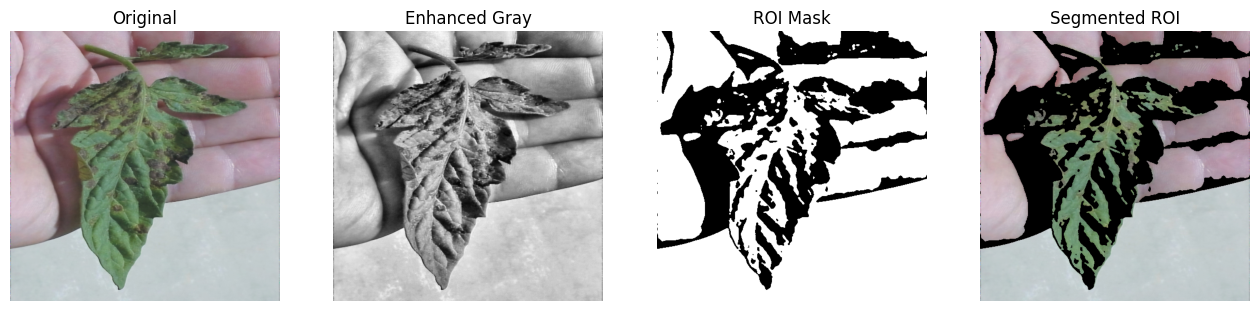

Features extracted and saved to: tomato_leaf_features.csv
       R_mean     R_std      G_mean      G_std      B_mean      B_std  \
0  174.706675  31.68119  173.982859  29.937592  173.483354  37.652993   

      contrast  dissimilarity  homogeneity       ASM    energy  correlation  \
0  1970.282275      16.342633      0.46549  0.074646  0.273214     0.862164   

      area    perimeter  eccentricity  
0  31665.0  1665.040764      0.947429  


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import regionprops, label
import pandas as pd

# --------------------------
# 1. Load Image
# --------------------------
img_path = "/content/img_11.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --------------------------
# 2. Preprocessing BEFORE ROI
# --------------------------

img_resized = cv2.resize(img, (512, 512))

# Convert to grayscale
gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

# Contrast enhancement using CLAHE (Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_enhanced = clahe.apply(gray)

# Noise reduction (median blur preserves edges)
denoised = cv2.medianBlur(gray_enhanced, 5)

# --------------------------
# 3. ROI Segmentation (Otsu Thresholding)
# --------------------------
_, mask = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
segmented = cv2.bitwise_and(img_resized, img_resized, mask=mask)

# Preview preprocessing stages
plt.figure(figsize=(16,4))
plt.subplot(1,4,1); plt.imshow(img_resized); plt.title("Original"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(gray_enhanced, cmap="gray"); plt.title("Enhanced Gray"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(mask, cmap="gray"); plt.title("ROI Mask"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(segmented); plt.title("Segmented ROI"); plt.axis("off")
plt.show()

# --------------------------
# 4. Feature Extraction
# --------------------------
feats = {}

# Color Features
for i, c in enumerate(['R','G','B']):
    channel = segmented[:,:,i]
    vals = channel[channel > 0]
    feats[f"{c}_mean"] = np.mean(vals) if len(vals) > 0 else 0
    feats[f"{c}_std"]  = np.std(vals) if len(vals) > 0 else 0

# Texture Features (GLCM)
gray_masked = rgb2gray(segmented)
gray_u8 = (gray_masked * 255).astype(np.uint8)
glcm = graycomatrix(gray_u8, distances=[5], angles=[0], symmetric=True, normed=True)
feats["contrast"]      = graycoprops(glcm, 'contrast')[0,0]
feats["dissimilarity"] = graycoprops(glcm, 'dissimilarity')[0,0]
feats["homogeneity"]   = graycoprops(glcm, 'homogeneity')[0,0]
feats["ASM"]           = graycoprops(glcm, 'ASM')[0,0]
feats["energy"]        = graycoprops(glcm, 'energy')[0,0]
feats["correlation"]   = graycoprops(glcm, 'correlation')[0,0]

# Shape Features
lbl = label(mask)
props = regionprops(lbl)
if len(props) > 0:
    feats["area"]        = props[0].area
    feats["perimeter"]   = props[0].perimeter
    feats["eccentricity"]= props[0].eccentricity
else:
    feats["area"] = feats["perimeter"] = feats["eccentricity"] = 0

df = pd.DataFrame([feats])
output_csv = "tomato_leaf_features.csv"
df.to_csv(output_csv, index=False)

print("Features extracted and saved to:", output_csv)
print(df)
